In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer,GroverOptimizer
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization import QuadraticProgram
from docplex.mp.model import Model

In [5]:
from qiskit import IBMQ
provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2021-03-22 12:19:03,114: Credentials are already in use. The existing account in the session will be replaced.


In [6]:
###### Fucntion for creating random adjacency matrix. #########

def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(i,number_of_vertices):
            if random.random()>probability or i==j:
                adj_matrix[i,j]=0
                adj_matrix[j,i]=0
    return adj_matrix

In [7]:
###### Function for converting binary number to decimal #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    
    return binary

In [8]:
####### Using Brute force ########

def brute_force(n, adj_matrix):
    best_cost = 0
    best_case = None
    for k in range(2**n):
        binary_k=dec_to_bin(k, n)
        temp_cost = 0
        for i in range(n):
            for j in range(n):
                temp_cost = temp_cost + adj_matrix[i,j]*binary_k[i]*(1-binary_k[j])
        if temp_cost > best_cost:
            best_cost = temp_cost
            best_case = binary_k

    return best_cost

In [9]:
######## Function for getting cost using numpyeigensolver ############

def using_numpyeigensolver(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = solver.solve(qudratic)
    best_cost = -1*result.fval
    return best_cost


In [10]:
def using_vqe(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    vqe = VQE(quantum_instance = backend)
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qudratic)
    return -1*result.fval
#using_vqe(15,create_adjacency_matrix(15,0.5))

In [11]:
def using_qaoa(n, adj_matrix):
    operator, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(operator, offset)
    qaoa_API = QAOA(p = 4,quantum_instance = backend ) 
    qaoa_optimiser = MinimumEigenOptimizer(qaoa_API)
    result = qaoa_optimiser.solve(qudratic)
    return -1*result.fval
#using_qaoa(15,create_adjacency_matrix(15,0.5))

In [12]:
def using_grover(n,adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    backend = BasicAer.get_backend('qasm_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance=backend)
    solver = MinimumEigenOptimizer(grover_optimizer)
    results = grover_optimizer.solve(qudratic)
    print("x={}".format(results.x))
    print("fval={}".format(results.fval))
#using_grover(5,create_adjacency_matrix(5,0.5))

In [13]:
def main_function(n1,n2):
    cost_vs_n = list()
    time_vs_n = list()
    ratio_vs_n = list()
    cost_brute = list()
    cost_numpy = list()
    cost_qaoa = list()
    cost_vqe = list()
    time_brute = list()
    time_numpy = list()
    ratio_qaoa = list()
    ratio_vqe = list()
    print( "n & brute_force & Numpysolver & QAOA & VQE")
    for i in range(n1,n2):
        for j in range(5):
            adj_matrix = create_adjacency_matrix(i,0.5)
            initial_time = time.time()
            cost_brute.append(brute_force(i,adj_matrix))
            final_time = time.time()
            time_brute.append(final_time - initial_time)

            initial_time = time.time()
            cost_numpy.append(using_numpyeigensolver(i, adj_matrix))
            final_time = time.time()
            time_numpy.append(final_time - initial_time)
            
            cost_qaoa.append(using_qaoa(i,adj_matrix))

            cost_vqe.append(using_vqe(i,adj_matrix))

            ratio_qaoa.append(cost_qaoa[j]/cost_brute[j])
            ratio_vqe.append(cost_vqe[j]/cost_brute[j])

        (n, cb, cn, cq, cv) = (i, sum(cost_brute)/5.0, sum(cost_numpy)/5.0, sum(cost_qaoa)/5.0, sum(cost_vqe)/5.0)
        (n, tb, tn) = (i, sum(time_brute)/5.0, sum(time_numpy)/5.0)
        (n, rq, rv) = (i, sum(ratio_qaoa)/5.0, sum(ratio_vqe)/5.0)

        print(n,'&', cb, '&', tb, '&', cn, '&', tn, '&', cq, '&', '&', cv, '&', rq, rv )    

        cost_vs_n.append((n, cb, cn, cq, cv))
        time_vs_n.append((n, tb, tn))
        ratio_vs_n.append((n, rq, rv))

        cost_brute.clear()
        cost_numpy.clear()
        cost_qaoa.clear()
        cost_vqe.clear()
        time_brute.clear()
        time_numpy.clear()
        ratio_qaoa.clear()
        ratio_vqe.clear()

    return cost_vs_n, time_vs_n
        

In [14]:
cost_vs_n, time_vs_n = main_function(4,16) 

n & brute_force & Numpysolver & QAOA & VQE
C:\Users\chitr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
4 & 2.0 & 0.0007912158966064453 & 2.0 & 0.03046736717224121 & 2.0 & & 2.0 & 1.0 1.0
5 & 4.2 & 0.0016083240509033204 & 4.2 & 0.03868870735168457 & 4.2 & & 4.2 & 1.0 1.0
6 & 6.4 & 0.002991771697998047 & 6.4 & 0.05038323402404785 & 6.4 & & 6.4 & 1.0 1.0
7 & 8.2 & 0.009810495376586913 & 8.2 & 0.06414608955383301 & 8.2 & & 8.2 & 1.0 1.0
8 & 9.8 & 0.025600194931030273 & 9.8 & 0.08337759971618652 & 9.8 & & 9.8 & 1.0 1.0
9 & 12.2 & 0.05326070785522461 & 12.2 & 0.11628451347351074 & 12.2 & & 12.2 & 1.0 1.0
10 & 17.0 & 0.13383727073669432 & 17.0 & 0.08099141120910644 & 17.0 & & 16.8 & 1.0 0.9866666666666667
11 & 19.8 & 0.3428913116455078 &

In [11]:
time_vs_n = list([(4,0.0001995086669921875, 0.02352170944213867), (5,0.0012054443359375, 0.018956804275512697), (6,0.003386688232421875,0.032717323303222655), 
(7, 0.006183815002441406, 0.027735233306884766), (8, 0.014959192276000977, 0.0414975643157959), (9, 0.03850221633911133, 0.06501736640930175),
(10, 0.10351777076721191, 0.03989362716674805), (11, 0.24115462303161622, 0.05347180366516113), (12, 0.9228158473968506, 0.15384068489074706),
(13, 2.329656410217285, 0.2827157497406006), (14, 4.8301835536956785, 0.28417673110961916), (15, 10.471866130828857, 0.4380645751953125) ])

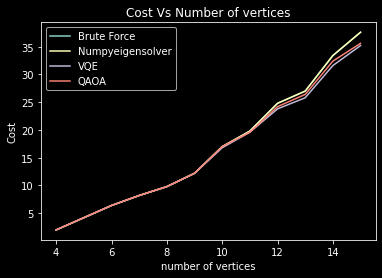

In [15]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
n, cb, cn, cq, cv = zip(*cost_vs_n)
plt.plot(n, cb, label = 'Brute Force')
plt.plot(n, cn, label = 'Numpyeigensolver')
plt.plot(n, cv, label = 'VQE')
plt.plot(n, cq, label = 'QAOA')
plt.legend()


In [16]:
ratio_vs_n = [(4, 1.0, 1.0), (5, 1.0, 1.0), (6, 1.0, 1.0), (7, 1.0, 1.0), (8, 1.0, 1.0), (9, 1.0, 1.0), (10, 1.0, 0.9866666666666667), (11, 0.9894736842105264, 0.9904761904761905), (12, 0.9753333333333334, 0.9596153846153846), (13, 0.9774725274725276, 0.9546419098143236), (14, 0.9691287878787879, 0.9470413595413596), (15, 0.9451483913403418, 0.9371630433549939)]

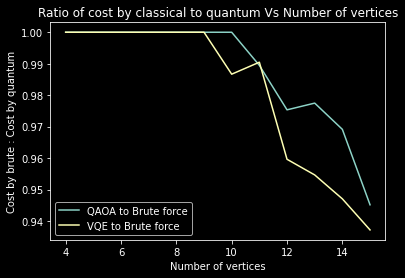

In [17]:
ratio = list()
for i in range(4,16):
    ratio.append((i, cost_vs_n[i-4][3]/cost_vs_n[i-4][1], cost_vs_n[i-4][4]/cost_vs_n[i-4][1]))
plt.title("Ratio of cost by classical to quantum Vs Number of vertices")
plt.ylabel("Cost by brute : Cost by quantum")
plt.xlabel("Number of vertices")
n, rq, rv = zip(*ratio_vs_n)
plt.plot(n, rq, label = 'QAOA to Brute force')
plt.plot(n, rv, label = 'VQE to Brute force')
plt.legend()

In [12]:
time_vs_n_qaoa = list([(4, 0.053),
 (5, 0.07),
 (6, 0.062),
 (7, 0.205),
 (8, 0.091),
 (9, 0.101),
 (10, 0.123),
 (11, 0.142),
 (12, 0.191),
 (13, 0.24),
 (14, 0.463),
 (15, 0.529)])

In [13]:
#time_vs_n_qaoa.append((15, 0.529))
time_vs_n_qaoa

[(4, 0.053),
 (5, 0.07),
 (6, 0.062),
 (7, 0.205),
 (8, 0.091),
 (9, 0.101),
 (10, 0.123),
 (11, 0.142),
 (12, 0.191),
 (13, 0.24),
 (14, 0.463),
 (15, 0.529)]

In [24]:
time_vs_n_vqe = list([(4, 0.082),
 (5, 0.126),
 (6, 0.174),
 (7, 0.204),
 (8, 0.238),
 (9, 0.304),
 (10, 0.365),
 (11, 0.445),
 (12, 0.683),
 (13, 0.912),
 (14, 1.523),
 (15, 1.902)])

In [25]:
#time_vs_n_vqe.append((15, 1.902))
time_vs_n_vqe

[(4, 0.082),
 (5, 0.126),
 (6, 0.174),
 (7, 0.204),
 (8, 0.238),
 (9, 0.304),
 (10, 0.365),
 (11, 0.445),
 (12, 0.683),
 (13, 0.912),
 (14, 1.523),
 (15, 1.902)]

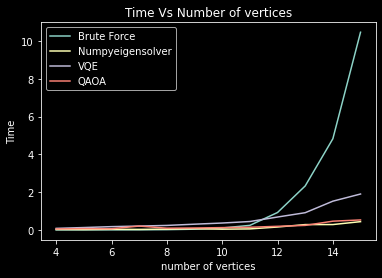

In [26]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
n, tb, tn= zip(*time_vs_n)
plt.plot(n, tb, label = 'Brute Force')
plt.plot(n, tn, label = 'Numpyeigensolver')
n, tv = zip(*time_vs_n_vqe)
plt.plot(n, tv, label = 'VQE')
n, tq = zip(*time_vs_n_qaoa)
plt.plot(n, tq, label = 'QAOA')
plt.legend()

In [27]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

In [28]:
from platform import python_version
python_version()

'3.8.6'

In [29]:
## Code by Chitresh Bhaskar Chaudhari 
## github.com/chit38